In [1]:
import json
import datetime
import altair as alt
import pandas as pd
import numpy as np
import os

hits = [
'2018-08-10_00-00-00', #0
'2018-08-29_11_32_44',
'2018-08-29_22-54-16', #2
'2018-09-05_21-38-43',
'2018-09-07_11-34-48',
'2018-09-08_09-41-18',
'2018-09-09_10-28-14', #6
'2018-09-10_10-36-44', #7
'2018-09-11_11-09-18',
]
base = 'hits/' + hits[8]
def cd(file):
    return os.path.join(base, file)

In [2]:
def duration_plot(assignments):
    times = []
    submit_times = []
    for l in assignments:
        submit = datetime.datetime.strptime(l['SubmitTime'][:-6], "%Y-%m-%d %H:%M:%S")
        accept = datetime.datetime.strptime(l['AcceptTime'][:-6], "%Y-%m-%d %H:%M:%S")
        submit_times.append(submit)
        diff = (submit - accept).total_seconds()/60.0
        times.append({"diff": diff})
    spec = {
      "data": {"values": times},
      "mark": "bar",
      "encoding": {
        "x": {
          "field": "diff",
          "type": "quantitative",
          "bin": {"step": 1} 
        },
        "y": {
          "aggregate": "count",
          "type": "quantitative"
        }
      }
    }
    print('min - max: ', min(submit_times), max(submit_times))
    print('mean duration: ', np.mean(list(map(lambda d: d['diff'], times))))
    return alt.VegaLite(spec)

min - max:  2018-09-11 11:11:27 2018-09-11 13:39:09
mean duration:  10.3905555556


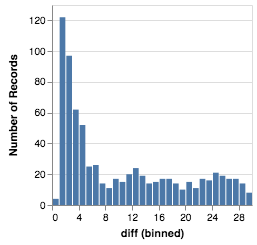

min - max:  2018-09-11 14:54:49 2018-09-11 17:05:55
mean duration:  12.5688


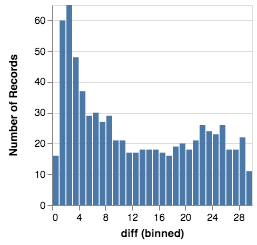

In [3]:
listener_assignments = json.load(open(cd('listener.assignments')))
speaker_assignments = json.load(open(cd('speaker.assignments')))
display(duration_plot(speaker_assignments))
display(duration_plot(listener_assignments))

In [4]:
import collections 

def by_worker(assign):
    workers = collections.defaultdict(int)
    for a in assign:
        workers[a['WorkerId']] += 1
    descending = sorted(workers.items(), key=lambda a: -a[1])
    return collections.OrderedDict(descending) 

listener_counts = by_worker(listener_assignments)
speaker_counts = by_worker(speaker_assignments)
intersection = set(speaker_counts.keys()).intersection(listener_counts.keys())

for k in intersection:
    print(k, listener_counts[k], speaker_counts[k])
print('speak: {} listener {} overlap {}'.format(len(speaker_counts), len(listener_counts), len(intersection)))

A15WCNO32MHBAF 3 11
AUI3R928P63B0 26 37
A1TGV7LT6LTIQU 17 14
AUPHYAKC58LPA 6 10
A374STD2W8N1U8 23 1
A1P0XSCJ9XAV74 16 6
A3CGA66ES1ZTKC 6 6
A3W24IE6P9O302 43 65
ASL76QYDI0QLK 15 16
AG5PMV0NS3A44 10 21
A2L5J9XWM1ODIL 8 43
A1IN92CQSAJE9Z 8 1
A33UQADFRXM0N 37 2
A2KAZBONNVNV5O 17 2
A2S96ZZ70YFPSK 17 7
APJJ1HHD2GGFS 3 2
A3F9N2P4NUUR7S 26 35
A1TVJ4HKOOIL6L 7 15
A35JQ3VLA4WBZC 14 21
AISNLDPD2DFEG 4 17
A03922113RU44GENR8ATX 13 6
ARB52L0KXB1DE 4 12
A36CQIFWEDEECU 11 20
AVBRJBJONL47I 9 2
A98E8M4QLI9RS 28 21
A2R3KI7FWWGBIV 26 50
speak: 68 listener 104 overlap 26


In [5]:
import pandas as pd
import collections
import mturk
from mturk.query_line import QueryLine
pd.set_option('display.max_colwidth', 200)
pd.set_option("display.max_rows", None)

def isfloat(string):
    try:
        float(string)
        return True
    except ValueError:
        return False
    
def reduce_formula(x):
    if x.find(':') == -1:
        print('COLON_NOT_FOUND', x)
        return 'COLON_NOT_FOUND'
    v = x[x.index(':')+1:]
    return x[:x.index(':')] + ('number' if isfloat(v) else v)

def to_html(spec):
    options = {'rendered': 'svg', 'width': 800, 'height': 800}
    return alt.utils.html.spec_to_html(spec, 'vega-lite', '3', '3', '2', embed_options=options)


processing 2018-08-29_22-54-16
processing 2018-09-05_21-38-43
processing 2018-09-07_11-34-48
processing 2018-09-08_09-41-18
processing 2018-09-09_10-28-14
processing 2018-09-10_10-36-44
processing 2018-09-11_11-09-18


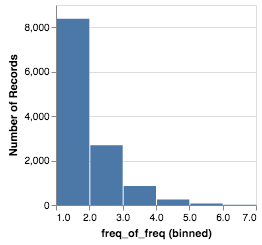

17725 12248 8376
number of listener pick_or_skip 40792
got 17725 examples, 134865 listeners log


In [14]:
from mturk import process_listener as pl
from mturk import guess_id as guess
# adds annotations

def aggregate_all():
    examples = []
    listener_log = []
    for h in hits[2:]:
        print('processing', h)
        speaker_path = os.path.join('hits', h, 'speaker.jsonl')
        listener_path = os.path.join('hits', h, 'listener.raw.jsonl')
        lines = [QueryLine(line.strip()) for line in open(speaker_path, 'r').readlines()]
        examples += [l for l in lines if l.is_example()]
        listener_log += [QueryLine(line.strip()) for line in open(listener_path, 'r').readlines()]
#     formulas = [l.example()['targetFormula'] for l in examples]
#     paths = list(map(lambda x: reduce_formula(x), formulas))
    paths = [reduce_formula(l.example()['targetFormula'])
             + guess.hash_query(l.json, keys=['context']) for l in examples]
    pathsset = set(paths)
    pathcounter = collections.Counter(paths)
    countisone = [k for k in pathcounter.keys() if pathcounter[k] == 1]
    freqfreq = pathcounter.values()
    spec = {
      "data": {"values": [{"freq_of_freq": v} for v in freqfreq]},
      "mark": "bar",
      "encoding": {
        "x": {
          "field": "freq_of_freq",
          "type": "quantitative",
          "bin": {"step": 1} 
        },
        "y": {
          "aggregate": "count",
          "type": "quantitative"
        }
      }
    }
    chart = alt.VegaLite(spec)
    display(chart)
    print(len(paths), len(pathsset), len(countisone))
    
    pl.process_listener(examples, listener_log)
    speakers, listeners = pl.aggregate_turker(examples)
    print('got {} examples, {} listeners log'.format(len(examples), len(listener_log)))
    return speakers, listeners

speakers, listeners = aggregate_all()

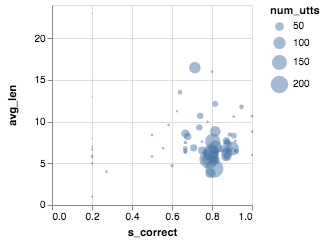

,avg_len,l_correct,l_skip,l_total,l_wrong,num_utts,s_correct,s_skip,s_total,s_wrong,total
avg_len,1.000000,-0.177621,-0.224731,-0.462083,0.409165,-0.166993,-0.034792,-0.009372,-0.175676,0.049230,-0.178986
l_correct,-0.177621,1.000000,-0.475561,0.286079,-0.874134,-0.241113,0.127129,-0.218993,-0.199350,-0.081214,0.239311
l_skip,-0.224731,-0.475561,1.000000,-0.064488,-0.011545,0.430978,-0.041503,0.119865,0.397522,0.008190,-0.045948
l_total,-0.462083,0.286079,-0.064488,1.000000,-0.289581,0.619805,0.043584,0.203103,0.611524,-0.133217,0.823188
l_wrong,0.409165,-0.874134,-0.011545,-0.289581,1.000000,-0.047312,-0.127151,0.179418,-0.072850,0.096232,-0.246656
num_utts,-0.166993,-0.241113,0.430978,0.619805,-0.047312,1.000000,0.311670,-0.221008,0.995746,-0.318404,0.956479
s_correct,-0.034792,0.127129,-0.041503,0.043584,-0.127151,0.311670,1.000000,-0.827167,0.315364,-0.974145,0.301889
s_skip,-0.009372,-0.218993,0.119865,0.203103,0.179418,-0.221008,-0.827167,1.000000,-0.223934,0.678821,-0.217811
s_total,-0.175676,-0.199350,0.397522,0.611524,-0.072850,0.995746,0.315364,-0.223934,1.000000,-0.322056,0.958059
s_wrong,0.049230,-0.081214,0.008190,-0.133217,0.096232,-0.318404,-0.974145,0.678821,-0.322056,1.000000,-0.306909


In [7]:
def q2row(l: QueryLine):
    return {'utterance': l.utterance(), 'workerId': l.worker_id(), 'targetFormula': l.example()['targetFormula']} 

def speaker2row(id, l: dict):
    return {'WorkerId': id, 'stats': l['stats'],
            'utts': ', '.join(l['utterances']), 'listeners': len(l['listeners'])}

def joint2row(id, l: dict):
    l['WorkerId'] = id
    return l

joint = collections.defaultdict(lambda: {'WorkerId':'', 'total': 0})

def fill_joint(rows, prefix):
    for wid, r in rows.items():
#         print('row', r)
        jr = joint[wid]
        jr['WorkerId'] = wid
        stats = r['stats']
        total = stats['correct'] + stats['wrong'] + stats['skip'] 
        correct, wrong, skip = 0.2, 0.6, 0.2
        if total != 0:
            correct = (stats['correct']) /  (total)
            wrong = (stats['wrong']) /  (total)
            skip = (stats['skip']) /  (total)
        jr[prefix + '_correct'] = correct 
        jr[prefix + '_wrong'] = wrong
        jr[prefix + '_skip'] = skip
        jr[prefix + '_total'] = total
        jr['total'] += total
        
def fill_utts(speakers):
    for wid, r in speakers.items():
#         print('row', r)
        jr = joint[wid]
        jr['WorkerId'] = wid
        utts = r['utterances']
        lenutt = len(utts)
        jr['num_utts'] = lenutt 
        jr['utts'] = utts if lenutt <= 10 else utts[0:5]
        jr['avg_len'] = np.mean([len(l.split(' ')) for l in utts])
        
fill_joint(speakers, 's')
fill_utts(speakers)
fill_joint(listeners, 'l')


records = [joint2row(k, v) for k,v in joint.items()]
agg_table = pd.DataFrame.from_records(records) 
agg_table.sort_values(by=['s_correct', 's_total', 'l_correct'], inplace=True, ascending=False)
# display(agg_table)
spec_list = []
spec_list += [{
  "data": {"values": records},
  "description": "accuracies",
  "mark": "circle",
  "encoding": {
    "x": {
      "field": "s_correct",
      "type": "quantitative"        
    },
    "y": {
      "field": "avg_len",
      "type": "quantitative"        
    },
    "size": {
        "field": "num_utts",
        "type": "quantitative"
    },
    "opacity": {"value": 0.5},
    "tooltip": {
        "field": "utts",
        "type": "nominal"
    }
  }
}]
spec_list += [{
  "data": {"values": records},
  "description": "correlation",
  "mark": "circle",
  "encoding": {
    "x": {
      "field": "s_correct",
      "type": "quantitative"        
    },
    "y": {
      "field": "l_total",
      "type": "quantitative"        
    },
    "size": {
        "field": "num_utts",
        "type": "quantitative"
    },
    "opacity": {"value": 0.5},
    "tooltip": {
        "field": "utts",
        "type": "nominal"
    }
  }
}]

chart = alt.VegaLite(spec_list[0])
display(chart)

for spec in spec_list:
    html = to_html(spec)
    name = spec['description']
    open(name + '.html', 'w').write(to_html(spec))

corr = agg_table.corr()
display(corr)
# display(agg_table)

In [8]:
ex_table = pd.DataFrame.from_records([speaker2row(k, v) for k,v in speakers.items()])
ex_table.sort_values(by=['listeners'])
display(ex_table)
open('visualize.html', 'w').write(table.to_html())

,WorkerId,listeners,stats,utts
0,AUI3R928P63B0,211,"{'correct': 190, 'wrong': 19, 'skip': 2}","Move X axis unit values upwards., Move X axis label upwards., Unbold x axis label., Add chart name XYZ., Change legend title color to blue, Change the style of the legend., Bold x axis, Bold x and..."
1,A98E8M4QLI9RS,223,"{'correct': 182, 'wrong': 31, 'skip': 10}","Move x-axis values up to line, Add blue shading to plot, Delete vertical grid lines, Make plot line bold, Delete x-axis values, label and grid lines, Add plot points and change shading to transluc..."
2,A3TUJHF9LW3M8N,20,"{'correct': 16, 'wrong': 3, 'skip': 1}","move x axis values to the right, shrink the graph down, Make the x axis line thicker, Change the y axis label to be diagonal , Move Europe down on the y axis, Remove vertical grid lines and x axis..."
3,A1QJFM0T6PHFD2,0,"{'correct': 0, 'wrong': 0, 'skip': 0}","EXTRA ADDING THE OUTLINE FOR SERIES HEADING, COLOR DIFFERENT, DATE MARKING LINE IS EXTRA, RED DOTS IS TOTALLY DIFFERENT PLACE APPEAR, RESPONSE TITLE IS APPEAR IN THE PERCENTAGE AREA"
4,A1GHD8U00E8YAV,53,"{'correct': 45, 'wrong': 6, 'skip': 2}","Add a title to the graph stating XYZ, Remove all data points, Center the X orgin 0 along the Y axis, Remove legend/key title, Decrease the thickness of the y axis line, Shift the graph down and to..."
5,A3B9FHCFOVFARJ,78,"{'correct': 68, 'wrong': 8, 'skip': 2}","Remove the x-axis color label, Remove the bars and add a legend with circles for each color, Move sum of yield up so it is immediately under the numbers, Move the y-axis pips slightly, Replace the..."
6,APZEO13SHI30O,78,"{'correct': 52, 'wrong': 17, 'skip': 9}","move label titled date closer to Y axis, Highlight plotted points, Change the size of plotted points, Move date label further away from Y axis, Show volume of activity of data, Show data as points..."
7,A25AJ66CYVUTBR,10,"{'correct': 5, 'wrong': 3, 'skip': 2}","Outline the whole graph in red, Shrink the size of the words, Shrink the entire graph, Remove all data from the graph, Move the vertical words closer to the graph, Turn the vertical words red"
8,A2ZYJ4VFTTE82U,6,"{'correct': 4, 'wrong': 2, 'skip': 0}","Make the plot label larger, Put X label at the bottom the plot is totally wrong., Adjust plot to the left side., Make Sharp Edges on the plot., Make the plot bigger., Eliminate Shaded marks on the..."
9,A2R3KI7FWWGBIV,270,"{'correct': 217, 'wrong': 38, 'skip': 15}","plot lines now have dots and the legend circles filled in, plot has dots and now overlap x axis numbers legend filled in, Legend is blue, word rank moved away from plot, Word day on x axis is now ..."


NameError: name 'table' is not defined